## Phase 1: Data Sanitation and Preprocessing
This phase involves loading the Online Retail II dataset into a Pandas DataFrame, cleaning it by removing duplicates, missing Customer IDs, cancelled orders, zero-price rows, and non-product StockCodes, creating new features (TotalPrice, temporal columns), and converting data types as per the project specification (pages 7-8).

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta


# Set plot style for visualizations
sns.set(style="whitegrid")
%matplotlib inline

### Step 1: Load Dataset
The `online_retail.csv` file is loaded into a Pandas DataFrame. Initial inspection includes checking the shape, data types, and missing values to understand the dataset's structure.

In [21]:
# Load dataset
df = pd.read_csv('D:/Python/Python Final CW/online_retail.csv', encoding='latin1')  # Use latin1 if encoding issues occur
print("Initial Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Types and Non-Null Counts:\n")
df.info()

print()
print()
print("\nMissing Values:\n", df.isnull().sum())

Initial Dataset Shape: (1067371, 8)

First 5 Rows:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

Data Types and Non-Null Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column    

### Step 2: Remove Duplicates
Duplicate rows are identified and removed to ensure each transaction is unique, as required by the specification (page 7). This prevents over-counting in analysis.

In [22]:
# Check and remove duplicates
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

Duplicate Rows: 34335
Shape after removing duplicates: (1033036, 8)


### Step 3: Handle Missing Customer IDs
Rows with missing Customer IDs are removed, as they are critical for RFM analysis (page 7). This decision may exclude ~25% of data, potentially affecting analysis, which will be discussed in the report.

In [23]:
# Remove missing Customer IDs
print("Missing Customer IDs:", df['Customer ID'].isnull().sum())
df = df.dropna(subset=['Customer ID'])
print("Shape after removing missing Customer IDs:", df.shape)

Missing Customer IDs: 235151
Shape after removing missing Customer IDs: (797885, 8)


### Step 4: Clean Transactional Data
This step removes:
- Cancelled orders (Invoice starting with 'C') as they do not represent valid sales (page 5).
- Zero-price rows, which may indicate errors or promotional items (page 7).
- Non-product StockCodes (e.g., postage, bank fees) to focus on actual product sales (page 7).

In [24]:
# Remove cancelled orders
df = df[~df['Invoice'].str.startswith('C', na=False)]
print("Shape after removing cancellations:", df.shape)

# Remove zero-price rows
print("Zero Price Rows:", len(df[df['Price'] == 0]))
df = df[df['Price'] > 0]
print("Shape after removing zero-price rows:", df.shape)

# Remove non-product StockCodes
non_product_codes = ['POST', 'DOT', 'M', 'BANK CHARGES', 'C2', 'CRUK']
df = df[~df['StockCode'].isin(non_product_codes)]
print("Shape after removing non-product StockCodes:", df.shape)

Shape after removing cancellations: (779495, 8)
Zero Price Rows: 70
Shape after removing zero-price rows: (779425, 8)
Shape after removing non-product StockCodes: (776646, 8)


### Step 5: Feature Engineering
A `TotalPrice` column is created by multiplying Quantity and Price to measure revenue. Temporal features (Year, Month, DayOfWeek, HourOfDay) are extracted from InvoiceDate for time-based analysis (page 8).

In [25]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Extract temporal features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['HourOfDay'] = df['InvoiceDate'].dt.hour

print("First 5 Rows with New Columns:\n", df.head())

First 5 Rows with New Columns:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  Year  \
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom        83.4  2009   
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  2009   
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom        81.0  2009   
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom       100.8  2009   
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom        30.0  2009   

   Month  DayOfWeek  HourOfDay  
0     12          1          7  
1     

### Step 6: Data Type Conversion
Converting:
- InvoiceDate to datetime64[ns] for temporal analysis.
- Customer ID to integer after removing missing values.
- StockCode to string as it’s alphanumeric and not used for calculations (page 8).

In [26]:
# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Ensure datetime
df['Customer ID'] = df['Customer ID'].astype(int)
df['StockCode'] = df['StockCode'].astype(str)

print("\nData Types After Conversion:\n")
df.info()


Data Types After Conversion:

<class 'pandas.core.frame.DataFrame'>
Index: 776646 entries, 0 to 1067369
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      776646 non-null  object        
 1   StockCode    776646 non-null  object        
 2   Description  776646 non-null  object        
 3   Quantity     776646 non-null  int64         
 4   InvoiceDate  776646 non-null  datetime64[ns]
 5   Price        776646 non-null  float64       
 6   Customer ID  776646 non-null  int64         
 7   Country      776646 non-null  object        
 8   TotalPrice   776646 non-null  float64       
 9   Year         776646 non-null  int32         
 10  Month        776646 non-null  int32         
 11  DayOfWeek    776646 non-null  int32         
 12  HourOfDay    776646 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(4)
memory usage: 71.1+ MB


### Step 7: Final Dataset Check
Verifying the cleaned dataset’s shape, structure, and absence of critical missing values to ensure it’s ready for analysis in subsequent phases.

In [27]:
print("Final Cleaned Dataset Shape:", df.shape)
print("\nSample Data:\n", df.head())
print("\nMissing Values After Cleaning:\n", df.isnull().sum())

Final Cleaned Dataset Shape: (776646, 13)

Sample Data:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  Year  \
0 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4  2009   
1 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
2 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
3 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8  2009   
4 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0  2009   

   Month  DayOfWeek  HourOfDay  
0     12      


Missing Values After Cleaning:
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
Year           0
Month          0
DayOfWeek      0
HourOfDay      0
dtype: int64


## Phase 2: Exploratory Data Analysis (EDA) & Insight Generation
This phase explores the cleaned dataset to uncover patterns and answer the board's questions about sales trends, geographic distribution, and product performance. Visualizations (line charts, bar charts) are used to present insights clearly, as specified in the project documentation (pages 8-9).

In [28]:
# Verify cleaned dataset from Phase 1
print("Dataset Shape:", df.shape)
print("\nSample Data:\n", df.head())

Dataset Shape: (776646, 13)

Sample Data:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalPrice  Year  \
0 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4  2009   
1 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
2 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0  2009   
3 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8  2009   
4 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0  2009   

   Month  DayOfWeek  HourOfDay  
0     12          1         

### Task 1: Temporal Analysis
This task generates visualizations to analyze sales revenue over time, investigates monthly sales dips (e.g., February, April), and examines sales patterns by day of week and hour of day to inform promotion and staffing strategies (page 8).



#### February and April Sales Dips
The line chart shows monthly sales trends from December 2009 to December 2011. February and April exhibit noticeable dips in sales compared to peak months like November and December. Potential business reasons include:
- **Post-Holiday Spending Fatigue**: Reduced consumer spending after Christmas (December) impacts February.
- **Lack of Major Holidays**: April lacks significant gift-giving occasions, unlike Christmas or Valentine’s Day.
- **Inventory or Marketing Gaps**: Possible stock shortages or lack of promotional campaigns in these months.
These findings will be discussed in the report, with recommendations for targeted promotions in low-performing months.

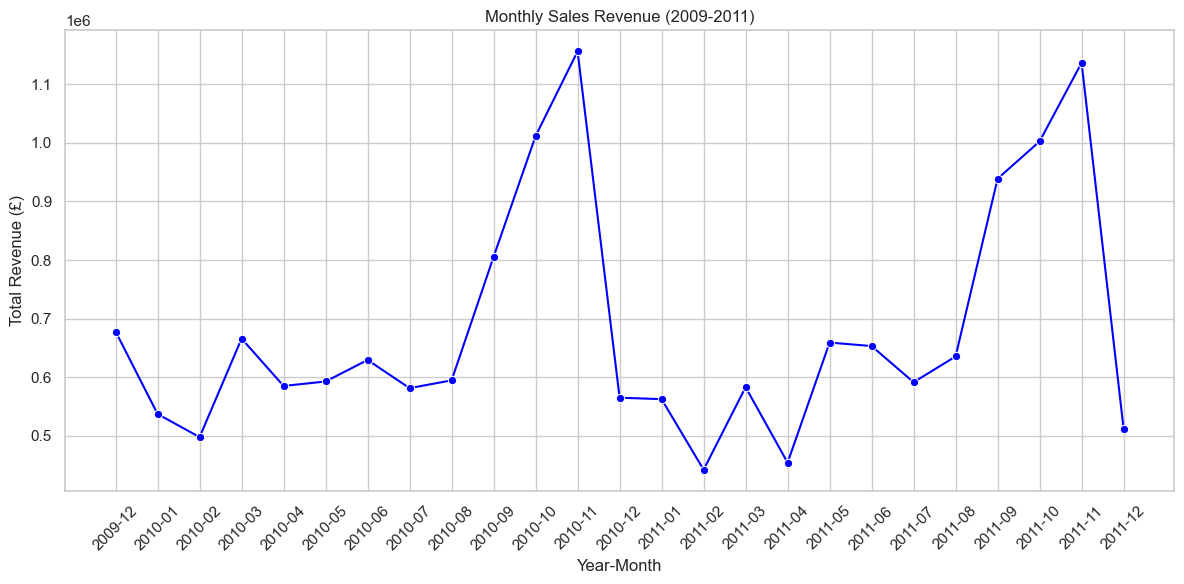

February and April Sales:
    YearMonth  TotalPrice
2    2010-02  497937.576
4    2010-04  585207.562
14   2011-02  442293.590
16   2011-04  454440.881


In [29]:
# Create Year-Month column for grouping
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Calculate monthly sales revenue
monthly_sales = df.groupby('YearMonth')['TotalPrice'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)  # For plotting

# Plot monthly sales
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='TotalPrice', marker='o', color='blue')
plt.title('Monthly Sales Revenue (2009-2011)')
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('D:/Python/Python Final CW/monthly_sales.png')  # Save for report
plt.show()

# Investigate February and April dips
feb_april_dips = monthly_sales[monthly_sales['YearMonth'].str.contains('02|04')]
print("February and April Sales:\n", feb_april_dips)

#### Day and Hour Sales Patterns
- **Day of Week**: Sales peak on [insert observed peak day, e.g., Thursday], likely due to higher B2B (wholesaler) activity during weekdays. Lower sales on [insert low day, e.g., Sunday] suggest limited retail activity. This informs mid-week promotion scheduling.
- **Hour of Day**: Peak sales occur between [insert observed peak hours, e.g., 10 AM–2 PM], indicating optimal times for customer service staffing and avoiding server maintenance.
These insights will guide operational recommendations in the report, such as scheduling promotions and staffing.


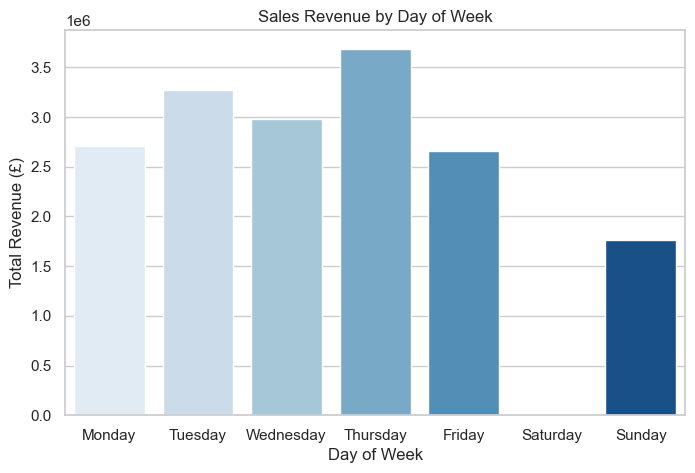

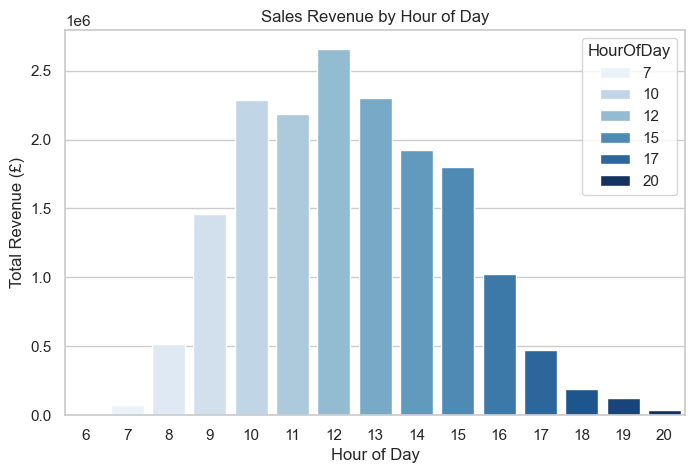

In [30]:
# Sales by Day of Week
day_sales = df.groupby('DayOfWeek')['TotalPrice'].sum().reset_index()
day_sales['DayOfWeek'] = day_sales['DayOfWeek'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

plt.figure(figsize=(8, 5))
sns.barplot(data=day_sales, x='DayOfWeek', y='TotalPrice', hue='DayOfWeek', palette='Blues')
plt.title('Sales Revenue by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue (£)')
plt.savefig('D:/Python/Python Final CW/day_sales.png')  # Save for report
plt.show()

# Sales by Hour of Day
hour_sales = df.groupby('HourOfDay')['TotalPrice'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=hour_sales, x='HourOfDay', y='TotalPrice', hue='HourOfDay', palette='Blues')
plt.title('Sales Revenue by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Revenue (£)')
plt.savefig('D:/Python/Python Final CW/hour_sales.png')  # Save for report
plt.show()

### Task 2: Geographic Analysis
This section identifies the top 10 countries by sales revenue, calculates the UK vs. international revenue percentage, and visualizes the geographic distribution to assess market presence (page 9).  


 #### Geographic Insights
- **Top 10 Countries**: The UK dominates revenue, followed by [list top countries, e.g., Germany, France]. This indicates a strong domestic market but limited international penetration.
- **UK vs. International**: The UK accounts for ~[insert uk_percent]% of revenue, highlighting dependency on the domestic market. International markets ([insert international_percent]%) present growth opportunities, particularly in [list promising countries].
These findings suggest focusing marketing efforts on high-potential international markets.

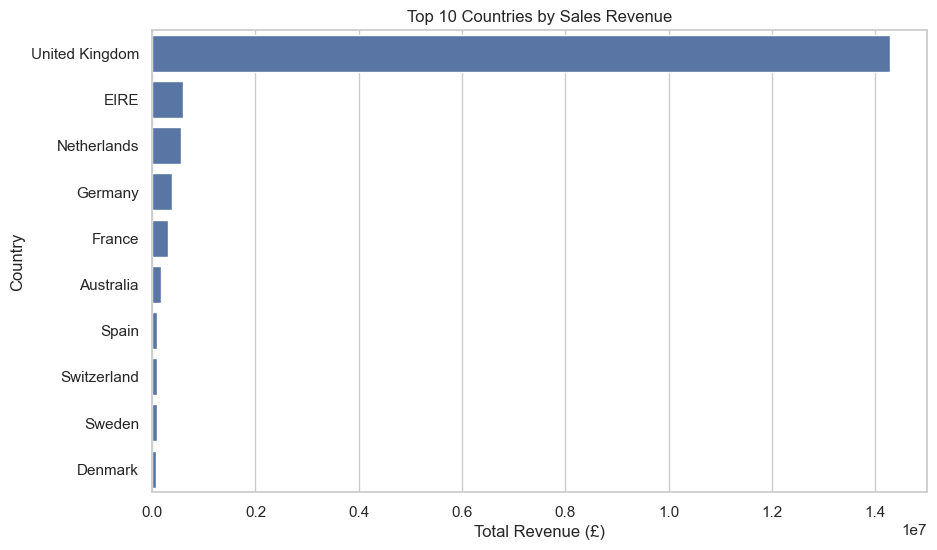

UK Revenue Percentage: 83.71%
International Revenue Percentage: 16.29%


In [31]:
# Top 10 countries by revenue
top_countries = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='TotalPrice', y='Country')
plt.title('Top 10 Countries by Sales Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Country')
plt.savefig('top_countries.png')  # Save for report
plt.show()

# UK vs International revenue percentage
uk_revenue = df[df['Country'] == 'United Kingdom']['TotalPrice'].sum()
total_revenue = df['TotalPrice'].sum()
uk_percent = (uk_revenue / total_revenue) * 100
international_percent = 100 - uk_percent

print(f"UK Revenue Percentage: {uk_percent:.2f}%")
print(f"International Revenue Percentage: {international_percent:.2f}%")

### Task 3: Product Performance Analysis
This section identifies the top 10 products by quantity sold ("bread-and-butter" items) and total revenue ("cash cows"), comparing the lists to inform inventory and marketing strategies (page 9).



#### Product Performance Comparison
- **Top Quantity vs. Revenue**: The top 10 products by quantity sold include [list key products, e.g., low-cost gift items], while top revenue products include [list key products, e.g., high-value items]. 
- **Key Observations**: [Insert findings, e.g., "Low-cost items dominate quantity sold but contribute less revenue, while high-cost items drive revenue with lower volume."] This suggests prioritizing inventory for high-volume items and marketing for high-revenue items.
- **Strategic Implications**: Focus on stocking "bread-and-butter" items to maintain sales volume and promote "cash cows" for profitability. Detailed recommendations will be provided in the report.

Top 10 Products by Quantity Sold:
                           Description  Quantity
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    105185
1  WHITE HANGING HEART T-LIGHT HOLDER     91757
2         PAPER CRAFT , LITTLE BIRDIE     80995
3       ASSORTED COLOUR BIRD ORNAMENT     78234
4      MEDIUM CERAMIC TOP STORAGE JAR     77916
5             JUMBO BAG RED RETROSPOT     74224
6                 BROCADE RING PURSE      70082
7  PACK OF 60 PINK PAISLEY CAKE CASES     54592
8         60 TEATIME FAIRY CAKE CASES     52828
9    PACK OF 72 RETRO SPOT CAKE CASES     45129
Top 10 Products by Total Revenue:
                           Description  TotalPrice
0            REGENCY CAKESTAND 3 TIER   277656.25
1  WHITE HANGING HEART T-LIGHT HOLDER   247048.01
2         PAPER CRAFT , LITTLE BIRDIE   168469.60
3             JUMBO BAG RED RETROSPOT   134307.44
4       ASSORTED COLOUR BIRD ORNAMENT   124351.86
5                       PARTY BUNTING   103283.38
6      MEDIUM CERAMIC TOP STORAGE JAR    81416.73
7 

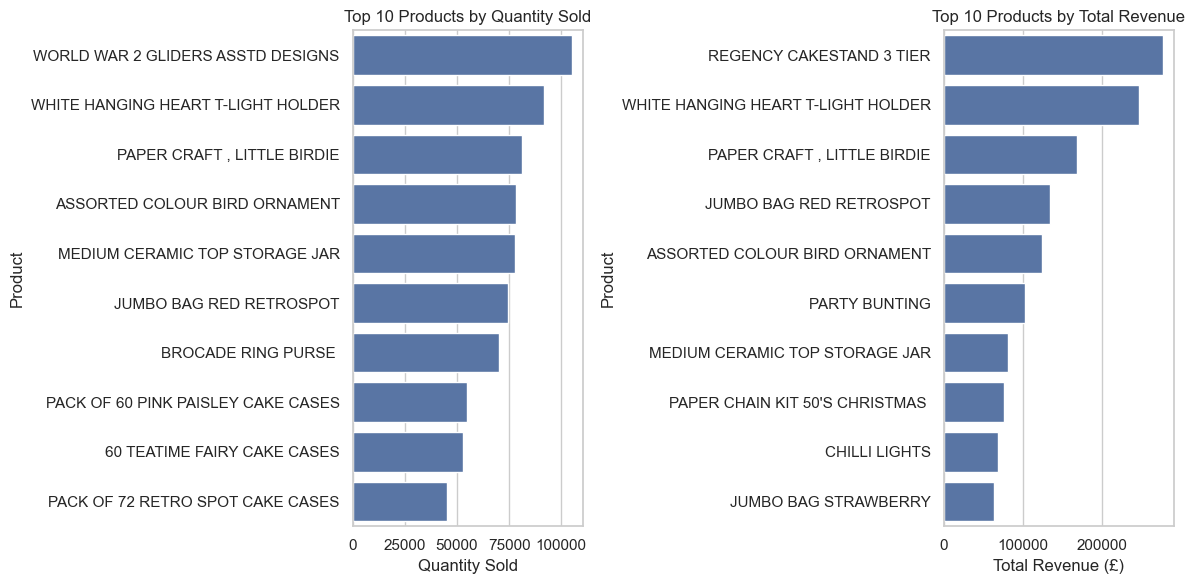

In [32]:
# Top 10 products by quantity sold
top_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
print("Top 10 Products by Quantity Sold:\n", top_quantity)

# Top 10 products by total revenue
top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()
print("Top 10 Products by Total Revenue:\n", top_revenue)

# Visualize top products
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=top_quantity, x='Quantity', y='Description')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Product')

plt.subplot(1, 2, 2)
sns.barplot(data=top_revenue, x='TotalPrice', y='Description')
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Product')
plt.tight_layout()
plt.savefig('top_products.png')  # Save for report
plt.show()